## Hands on Practical Deep learning with PyTorch
### Sign Language Digits Dataset
https://www.kaggle.com/ankitjha/hands-on-practical-deep-learning-with-pytorch/notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [14]:
data = np.load('./data/X.npy')*255
target = np.load('./data/Y.npy')
Y = np.zeros(data.shape[0])
Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = .02, random_state = 2) 
## splitting into train and test set

In [15]:
X_train.shape, X_train.max(), X_train.min()

((2020, 64, 64), 255.0, 1.0)

-  Data must be wrapped on a Dataset parent class where the methods getitem and len must be overrided. Not that, the data is not loaded on memory by now.
- The Dataloader reads the data and puts it into memory.

- torchvision - It is used to load and prepare dataset. Using it you can create transformations on the input data. 

- transforms - It is used for preprocessing images and performing operations sequentially. 

- num_workers - It is used for multiprocessing.Normally, num_workers = 4 * (number of gpus) works well.

In [16]:
print(X_train.shape)
x = X_train[77:78,...]
print(x.shape)
x = x.reshape((-1, 64, 64)).astype(np.uint8)[:, :, :, None]
print(x.shape)

(2020, 64, 64)
(1, 64, 64)
(1, 64, 64, 1)


In [17]:
from torch.utils.data import Dataset


class DatasetProcessing(Dataset):
    def __init__(self, data, target, transform=None):
        # used to initialise the class variables - transform, data, target
        self.transform = transform
        # print(data.shape)
        #self.data = torch.from_numpy(data.reshape((-1, 64, 64))[:, None, :, :])
        self.data = data.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
        # print(self.data.shape)
        self.target = torch.from_numpy(target).long()
        # needs to be in torch.LongTensor dtype

    def __getitem__(self, index):
        # used to retrieve the X and y index value and return it
        return self.transform(self.data[index]), self.target[index]
#         return self.data[index], self.target[index]

    def __len__(self):
        # returns the length of the data
        return len(list(self.data))

In [45]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])
dset_train = DatasetProcessing(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(
    dset_train, batch_size=4, shuffle=True, num_workers=4)

In [46]:
print(X_train.shape, y_train.shape)
print(
      np.min(X_train), 
      np.max(X_train),
     )
xx, yy = next(iter(train_loader))
print(xx.shape, yy.shape)
print(
      torch.min(xx),
      torch.max(xx),
     )

(2020, 64, 64) (2020,)
1.0 255.0
torch.Size([4, 1, 64, 64]) torch.Size([4])
-0.772549033164978 0.929411768913269


In [47]:
data= torch.from_numpy(X_train.reshape((-1, 64, 64))[:, None, :, :])
data.shape, data[1].shape

(torch.Size([2020, 1, 64, 64]), torch.Size([1, 64, 64]))

In [48]:
results = transforms.ToPILImage()(X_train.reshape((-1, 64, 64)).astype(np.uint8)[:, :, :, None][1])
results.show()

In [49]:
from torch import nn
from torch.autograd import Variable
print(xx.shape)
nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1))(Variable(xx)).shape

torch.Size([4, 1, 64, 64])


torch.Size([4, 32, 64, 64])

In [57]:
dset_test = DatasetProcessing(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    dset_test, batch_size=2200, shuffle=True, num_workers=0)

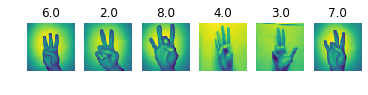

In [51]:
import matplotlib.pyplot as plt
for num, x in enumerate(X_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

In [52]:
from torch import nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [53]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    print('Cuda!')
    model = model.cuda()
    criterion = criterion.cuda()

Cuda!


In [54]:
from torch.autograd import Variable
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        #print(data.size())
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        #print(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [55]:
import torch.nn.functional as F
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0

    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).data[0]
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(data_loader.dataset)

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [60]:
n_epochs = 2

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)
    evaluate(test_loader)

Train Epoch: 0 [400/2020 (20%)]	Loss: 2.675716
Train Epoch: 0 [800/2020 (40%)]	Loss: 0.274785
Train Epoch: 0 [1200/2020 (59%)]	Loss: 0.373519
Train Epoch: 0 [1600/2020 (79%)]	Loss: 1.439339
Train Epoch: 0 [2000/2020 (99%)]	Loss: 0.656083

Average loss: 0.3925, Accuracy: 1805/2020 (89.356%)


Average loss: 0.4044, Accuracy: 38/42 (90.476%)

Train Epoch: 1 [400/2020 (20%)]	Loss: 1.504576
Train Epoch: 1 [800/2020 (40%)]	Loss: 0.968628
Train Epoch: 1 [1200/2020 (59%)]	Loss: 0.359423
Train Epoch: 1 [1600/2020 (79%)]	Loss: 1.715366
Train Epoch: 1 [2000/2020 (99%)]	Loss: 0.072879

Average loss: 0.3805, Accuracy: 1820/2020 (90.099%)


Average loss: 0.4559, Accuracy: 36/42 (85.714%)



In [72]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Horizontal Flip
    transforms.Scale(256),  #Scaling the input
    transforms.RandomCrop(64, padding=4),  # Centre Crop
    transforms.ToTensor(),  #Convereting the input to tensor
    transforms.Normalize([0.5], [0.5])
])
dset_train = DatasetProcessing(X_train, y_train, train_transform)
train_loader = torch.utils.data.DataLoader(
    dset_train, batch_size=4, shuffle=True, num_workers=4)

In [66]:
n_epochs = 20

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)
    evaluate(test_loader)


Average loss: 2.3134, Accuracy: 190/2020 (9.406%)


Average loss: 2.0575, Accuracy: 19/42 (45.238%)


Average loss: 2.3132, Accuracy: 203/2020 (10.050%)


Average loss: 2.0619, Accuracy: 18/42 (42.857%)


Average loss: 2.3090, Accuracy: 187/2020 (9.257%)


Average loss: 2.0662, Accuracy: 18/42 (42.857%)


Average loss: 2.3065, Accuracy: 206/2020 (10.198%)


Average loss: 2.0711, Accuracy: 18/42 (42.857%)


Average loss: 2.3134, Accuracy: 219/2020 (10.842%)


Average loss: 2.0736, Accuracy: 18/42 (42.857%)


Average loss: 2.3112, Accuracy: 230/2020 (11.386%)


Average loss: 2.0766, Accuracy: 18/42 (42.857%)


Average loss: 2.3058, Accuracy: 224/2020 (11.089%)


Average loss: 2.0793, Accuracy: 17/42 (40.476%)


Average loss: 2.3145, Accuracy: 218/2020 (10.792%)


Average loss: 2.0810, Accuracy: 17/42 (40.476%)


Average loss: 2.3085, Accuracy: 233/2020 (11.535%)


Average loss: 2.0820, Accuracy: 17/42 (40.476%)


Average loss: 2.3042, Accuracy: 212/2020 (10.495%)


Average loss: 2.0834,

In [73]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        #1st net
        self.conv1_1 = nn.Conv2d(
            1, 4, kernel_size=(4, 4), padding=(3, 3), stride=(2, 2))  #34 * 34
        self.conv1_2 = nn.Conv2d(
            4, 8, kernel_size=(4, 4), padding=(2, 2), stride=(2,
                                                              2))  #18 * 18 #mp
        self.fc1_1 = nn.Linear(8 * 9 * 9, 32)  #dropout = 0.2
        self.fc1_1_drop = nn.Dropout(p=0.2)
        self.fc1_2 = nn.Linear(32, 10)

        #2nd net
        self.conv2_1 = nn.Conv2d(
            1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  #64 * 64
        self.conv2_2 = nn.Conv2d(
            3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1,
                                                              1))  #64 * 64 #mp
        self.conv2_2_drop = nn.Dropout2d()
        self.conv2_3 = nn.Conv2d(
            6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  #64 * 64
        self.conv2_4 = nn.Conv2d(
            12, 24, kernel_size=(3, 3), stride=(1, 1),
            padding=(1, 1))  #64 * 64 #mp
        self.conv2_4_drop = nn.Dropout2d()
        self.fc2_1 = nn.Linear(24 * 16 * 16, 120)  #dropout = 0.5
        self.fc2_1_drop = nn.Dropout(p=0.5)
        self.fc2_2 = nn.Linear(120, 10)

        #3rd net
        self.conv3_1 = nn.Conv2d(
            1, 4, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))  #22 * 22
        self.conv3_2 = nn.Conv2d(
            4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1,
                                                              1))  #22 * 22 #mp
        self.conv3_3 = nn.Conv2d(
            8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  #11 * 11
        self.fc3_1 = nn.Linear(16 * 11 * 11, 64)  #dropout = 0.4
        self.fc3_1_drop = nn.Dropout(p=0.4)
        self.fc3_2 = nn.Linear(64, 10)

    def forward(self, x, y, z):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.pool(self.conv1_2(x)))
        x = x.view(-1, 648)  #can also do x.view(-1, 1)
        x = F.relu(self.fc1_1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1_2(x))

        y = F.relu(self.conv2_1(y))
        y = F.relu(self.pool(self.conv2_2_drop(self.conv2_2(y))))
        y = F.relu(self.conv2_3(y))
        y = F.relu(self.pool(self.conv2_4_drop(self.conv2_4(y))))
        y = y.view(-1, 256 * 24)
        y = F.relu(self.fc2_1_drop(self.fc2_1(y)))
        y = F.relu(self.fc2_2(y))

        z = F.relu(self.conv3_1(z))
        z = F.relu(self.pool(self.conv3_2(z)))
        z = F.relu(self.conv3_3(z))
        z = z.view(-1, 16 * 121)
        z = F.relu(self.fc3_1_drop(self.fc3_1(z)))
        z = F.relu(self.fc3_2(z))

        x = torch.cat((x, y, z))

        return F.sigmoid(x)

In [74]:
def train_ensemble(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        #print(data.size())
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        #print(target)
        optimizer.zero_grad()
        target = torch.cat((target, target, target))
        output = model(data, data, data)
        loss = criterion(output, target)
        #output_list = [model(data, data, data).unsqueeze(0) for model in model_list]
        #output = torch.mean(torch.cat(output_list), 0).squeeze()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [77]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

n_epochs = 5

for epoch in range(n_epochs):
    train_ensemble(epoch)
#     evaluate(train_loader)

Train Epoch: 0 [400/2020 (20%)]	Loss: 2.302446
Train Epoch: 0 [800/2020 (40%)]	Loss: 2.302585
Train Epoch: 0 [1200/2020 (59%)]	Loss: 2.302585
Train Epoch: 0 [1600/2020 (79%)]	Loss: 2.302585
Train Epoch: 0 [2000/2020 (99%)]	Loss: 2.298962
Train Epoch: 1 [400/2020 (20%)]	Loss: 2.307820
Train Epoch: 1 [800/2020 (40%)]	Loss: 2.302585
Train Epoch: 1 [1200/2020 (59%)]	Loss: 2.302585
Train Epoch: 1 [1600/2020 (79%)]	Loss: 2.302585
Train Epoch: 1 [2000/2020 (99%)]	Loss: 2.302585
Train Epoch: 2 [400/2020 (20%)]	Loss: 2.307823
Train Epoch: 2 [800/2020 (40%)]	Loss: 2.302585
Train Epoch: 2 [1200/2020 (59%)]	Loss: 2.302585
Train Epoch: 2 [1600/2020 (79%)]	Loss: 2.302585
Train Epoch: 2 [2000/2020 (99%)]	Loss: 2.302585
Train Epoch: 3 [400/2020 (20%)]	Loss: 2.302585
Train Epoch: 3 [800/2020 (40%)]	Loss: 2.302585
Train Epoch: 3 [1200/2020 (59%)]	Loss: 2.302585
Train Epoch: 3 [1600/2020 (79%)]	Loss: 2.302585
Train Epoch: 3 [2000/2020 (99%)]	Loss: 2.302585
Train Epoch: 4 [400/2020 (20%)]	Loss: 2.302585
T